# Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import plotly.graph_objects as go


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing

In [2]:
# make df with column names year, month, decimal date, SSN, M1, M2, M3, M4, M5 from file 5c_obs_sim_v1.dat
df = pd.read_csv('5c_obs_sim_v1.dat', sep='\s+', header=None, names=['year', 'month', 'decimal_date', 'SSN', 'M1', 'M2', 'M3', 'M4', 'M5'])

# normalize data to be between 0 and 1 using max value from SSN
M = df['SSN'].max()
df['SSN'] = df['SSN'] / M
for i in range(1, 6):
    df[f'M{i}'] = df[f'M{i}'] / M

df.head()

,year,month,decimal_date,SSN,M1,M2,M3,M4,M5
0,1965,1,1965.042,0.073851,0.0,0.0,0.0,0.004615,0.000511
1,1965,2,1965.123,0.075998,0.0,0.0,0.0,0.005838,0.001198
2,1965,3,1965.204,0.079004,0.0,0.0,0.0,0.007768,0.001380
3,1965,4,1965.288,0.085444,0.0,0.0,0.0,0.010287,0.001755
4,1965,5,1965.371,0.091026,0.0,0.0,0.0,0.013512,0.002240


In [3]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['decimal_date'], y=df['SSN'], name='SSN'))

for i in range(1, 6):
    fig.add_trace(go.Scatter(x=df['decimal_date'], y=df[f'M{i}'], name=f'M{i}', visible=True))

fig.update_yaxes(range=[-0.2, 1])
fig.show()

In [4]:
class MixedDataGenerator:
    def __init__(self,
                 model_series,
                 observed_series,
                 model_series_input_size,
                 observed_series_input_size,
                 horizon=18):
        self.model_series = model_series
        self.observed_series = observed_series
        self.model_series_input_size = model_series_input_size
        self.horizon = horizon
        self.observed_series_input_size = observed_series_input_size
        self.X, self.y = self._prepare_data()
        
    def _prepare_data(self):
        l = len(self.model_series) - self.model_series_input_size - self.observed_series_input_size - self.horizon
        ll = max(self.model_series_input_size, self.observed_series_input_size)
        X = np.zeros((l, self.model_series_input_size + self.horizon + self.observed_series_input_size))
        y = np.zeros((l, self.horizon))
        for i in range(l):
            X[i, :self.model_series_input_size + self.horizon] = self.model_series[i+1:i+1 + self.model_series_input_size + self.horizon]
            X[i, self.model_series_input_size + self.horizon:] = self.observed_series[i:i + self.observed_series_input_size]
            y[i] = self.observed_series[i + ll: i + ll + self.horizon]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
MODEL_SERIES_INPUT_SIZE = 4
OBSERVED_SERIES_INPUT_SIZE = 4

model_series = df['M1'].values
observed_series = df['SSN'].values

model_series = torch.tensor(model_series, dtype=torch.float32)
observed_series = torch.tensor(observed_series, dtype=torch.float32)

data = MixedDataGenerator(model_series, observed_series, MODEL_SERIES_INPUT_SIZE, OBSERVED_SERIES_INPUT_SIZE)

In [6]:
data.X.shape, data.y.shape

(torch.Size([622, 26]), torch.Size([622, 18]))

In [7]:
data.X[0], data.y[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0001,
         0.0005, 0.0011, 0.0021, 0.0035, 0.0053, 0.0079, 0.0118, 0.0170, 0.0243,
         0.0347, 0.0495, 0.0731, 0.1043, 0.0739, 0.0760, 0.0790, 0.0854]),
 tensor([0.0910, 0.0936, 0.0970, 0.1022, 0.1082, 0.1219, 0.1378, 0.1511, 0.1705,
         0.1924, 0.2112, 0.2289, 0.2486, 0.2722, 0.3066, 0.3448, 0.3843, 0.4113]))

In [29]:
data.X[1], data.y[1]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0001, 0.0005,
         0.0011, 0.0021, 0.0035, 0.0053, 0.0079, 0.0118, 0.0170, 0.0243, 0.0347,
         0.0495, 0.0731, 0.1043, 0.1363, 0.0760, 0.0790, 0.0854, 0.0910]),
 tensor([0.0936, 0.0970, 0.1022, 0.1082, 0.1219, 0.1378, 0.1511, 0.1705, 0.1924,
         0.2112, 0.2289, 0.2486, 0.2722, 0.3066, 0.3448, 0.3843, 0.4113, 0.4268]))

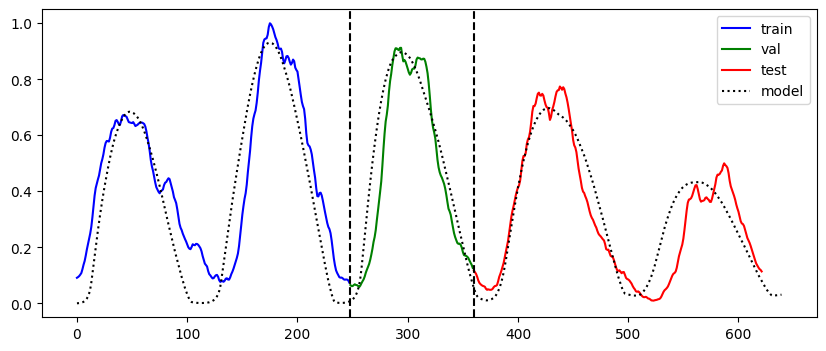

In [8]:
test_val_size = 0.6
val_size = 0.7

train_data_X, test_data_X, train_data_y, test_data_y = train_test_split(data.X, data.y, test_size=test_val_size, shuffle=False)
val_data_X, test_data_X, val_data_y, test_data_y = train_test_split(test_data_X, test_data_y, test_size=val_size, shuffle=False)

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data_X, train_data_y), batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(val_data_X, val_data_y), batch_size=64, shuffle=False)


# plot train val test data with 3 different colors and dotted model series. make shift for x axis to show all data
plt.figure(figsize=(10, 4))
plt.plot(train_data_y[:, 0], label='train', color='blue')
# make shift on x to plot val after train
plt.plot(np.arange(len(train_data_y), len(train_data_y) + len(val_data_y)), val_data_y[:, 0], label='val', color='green')
plt.plot(np.arange(len(train_data_y) + len(val_data_y), len(train_data_y) + len(val_data_y) + len(test_data_y)), test_data_y[:, 0], label='test', color='red')
plt.plot(model_series[MODEL_SERIES_INPUT_SIZE + OBSERVED_SERIES_INPUT_SIZE:], label='model', color='black', linestyle='dotted')
# add 2 vertical lines to show train val test split
plt.axvline(len(train_data_y), color='black', linestyle='dashed')
plt.axvline(len(train_data_y) + len(val_data_y), color='black', linestyle='dashed')
plt.legend()

# Model building

In [10]:
class NARX(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NARX, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            # nn.Softplus(),
            nn.Sigmoid(),
            nn.Linear(hidden_size, output_size), 
            nn.Softplus()
            # nn.ReLU()
        )

    def forward(self, x):
        out = self.net(x)
        return out
    
    def train_model(self, trainloader, valloader, data, epochs=100, lr=0.001):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        train_losses = []
        val_losses = []
        autoregressive_rmses = []
        for i in tqdm(range(epochs), desc='Training', unit='epoch'):
            self.train()
            train_loss = 0
            for X, y in trainloader:
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                output = self(X)
                # loss = criterion(output, y.unsqueeze(1))
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_losses.append(train_loss / len(trainloader))
            self.eval()
            val_loss = 0
            with torch.no_grad():
                for X, y in valloader:
                    X, y = X.to(device), y.to(device)
                    output = self(X)
                    # loss = criterion(output, y.unsqueeze(1))
                    loss = criterion(output, y)
                    val_loss += loss.item()
                val_losses.append(val_loss / len(valloader))
        
                    
            
        return train_losses, val_losses, autoregressive_rmses

    def autoregressive_prediction(self, data): 
        preds = []
        self.eval()
        X = data[0]
        for i in range(len(data) - 1):
            with torch.no_grad():
                pred = self(X.to(device))
                preds.append(pred.item())
                model_s = data[i + 1, :MODEL_SERIES_INPUT_SIZE]
                obs_s = X[MODEL_SERIES_INPUT_SIZE + 1:]
                obs_s = torch.cat((obs_s, pred))
                X = torch.cat((model_s, obs_s))
        return preds
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [62]:
model = NARX(input_size=MODEL_SERIES_INPUT_SIZE + OBSERVED_SERIES_INPUT_SIZE + 18, hidden_size=24, output_size=18)
model.to(device)

NARX(
  (net): Sequential(
    (0): Linear(in_features=26, out_features=24, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=24, out_features=18, bias=True)
    (3): Softplus(beta=1, threshold=20)
  )
)

# Training

In [63]:
train_losses, val_losses, autormses = model.train_model(trainloader, valloader, data, epochs=1500, lr=0.001)

Training: 100%|██████████| 1500/1500 [00:18<00:00, 79.82epoch/s]


In [15]:
# load model
model.load_state_dict(torch.load('narx_model_sigmoid.pth'))

<All keys matched successfully>

In [13]:
# save model
torch.save(model.state_dict(), 'narx_model_smooth.pth')

In [60]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(train_losses)), y=train_losses, mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(len(val_losses)), y=val_losses, mode='lines', name='Validation Loss'))
fig.update_layout(title='Training and Validation Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()


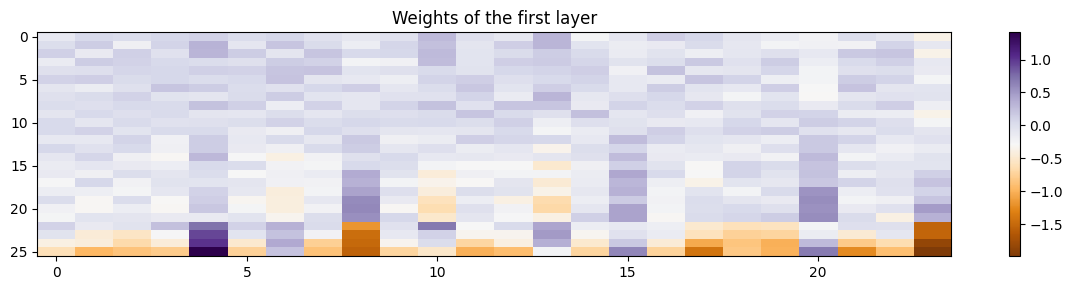

In [54]:
# plot weights of first layer as 2D image
plt.figure(figsize=(12, 3))
plt.imshow(model.net[0].weight.detach().cpu().numpy().T, aspect='auto', cmap='PuOr')
plt.colorbar()
plt.title('Weights of the first layer')
plt.tight_layout()
plt.show()

# Results

In [55]:
model.eval()
x = data.X.to(device)
y = data.y.to(device)
preds = model(x.to(device))


fig = go.Figure()
fig.add_trace(go.Scatter(y=y.cpu().numpy()[:, 0], name='True', mode='lines', line=dict(color='green')))
fig.add_trace(go.Scatter(y=preds.detach().cpu().numpy()[:, 0], name='Predicted', mode='lines', line=dict(color='red')))
# train-val line
fig.add_shape(type='line', x0=(1 - test_val_size) * len(x), x1=(1 - test_val_size) * len(x), y0=0, y1=1, line=dict(color='gray', width=1, dash='dash'))
fig.add_shape(type='line', x0=0.8 * len(x), x1=0.8 * len(x), y0=0, y1=1, line=dict(color='gray', width=1, dash='dash'))
# add M1
fig.add_trace(go.Scatter(y=model_series, name='M1', mode='lines', line=dict(color='blue', dash='dash', width=1)))
fig.update_layout(title='Results', xaxis_title='Time', yaxis_title='Value')
fig.show()


In [64]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Функция для расчета RMSE
def calculate_rmse(true, predicted):
    return np.sqrt(mean_squared_error(true, predicted))

# Функция для предсказаний и вычисления RMSE на всём тестовом периоде
def evaluate_on_test_data(model, test_data_X, test_data_y, horizon=18):
    model.eval()
    num_samples = len(test_data_X) - horizon
    rmse_per_step = np.zeros(horizon)

    for step in range(horizon):
        preds = []
        true_vals = []
        for i in range(num_samples):
            with torch.no_grad():
                # Выполняем предсказание с модели
                pred = model(test_data_X[i].unsqueeze(0).to(device)).cpu().numpy()
                preds.append(pred[0, step] * M)
                true_vals.append(test_data_y[i, step].item() * M)
                
        # Вычисляем RMSE для данного шага
        rmse_per_step[step] = calculate_rmse(true_vals, preds)

    # Средний RMSE по всем шагам
    avg_rmse = np.mean(rmse_per_step)
    return rmse_per_step, avg_rmse

# Оценка модели на тестовом периоде
rmse_per_step, avg_rmse = evaluate_on_test_data(model, test_data_X, test_data_y)

# Вывод результатов
print(f"Средний RMSE по всему тестовому периоду: {avg_rmse}")
for step in range(18):
    print(f"RMSE для предсказания на шаге {step+1}: {rmse_per_step[step]}")


Средний RMSE по всему тестовому периоду: 15.27995936320057
RMSE для предсказания на шаге 1: 6.285481626772613
RMSE для предсказания на шаге 2: 7.257527397375729
RMSE для предсказания на шаге 3: 9.346536342898695
RMSE для предсказания на шаге 4: 9.921188770995963
RMSE для предсказания на шаге 5: 12.02143081957862
RMSE для предсказания на шаге 6: 12.254148555293828
RMSE для предсказания на шаге 7: 13.513099836694462
RMSE для предсказания на шаге 8: 14.570758134616181
RMSE для предсказания на шаге 9: 15.815350413010746
RMSE для предсказания на шаге 10: 16.309147948301
RMSE для предсказания на шаге 11: 17.364178848933058
RMSE для предсказания на шаге 12: 17.980357441731904
RMSE для предсказания на шаге 13: 18.748975815255413
RMSE для предсказания на шаге 14: 19.534484482483162
RMSE для предсказания на шаге 15: 20.06701738737181
RMSE для предсказания на шаге 16: 20.726165054109188
RMSE для предсказания на шаге 17: 21.29491297818131
RMSE для предсказания на шаге 18: 22.028506684006626
